In [1]:
from matplotlib import pyplot as plt
from matplotlib import gridspec 
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
import os
from scikit_posthocs import global_f_test

from bids import BIDSLayout

In [2]:
layout = BIDSLayout('bids_temp', derivatives = True)

## Motor task (encoding model)

In [3]:
subjects = layout.get_subjects(scope = 'voxelwise')
print(subjects)

['01', 'dd', 'gg', 'uu']


In [4]:
print('\nANN-based encoding model vs. at-chance prediction')
print('whole-brain p-values (one-tailed R2-max):\n')
ps = []
H0_all = []
for sub in subjects:
    f = layout.get(subject = sub, desc = 'model', suffix = 'r2')[0]
    H0 = np.load(f).max(1) # maximum R2 over vertices/voxels
    H0_all.append(H0)
    max_r2 = H0[0]
    p = (H0 >= max_r2).mean()
    print('sub-%s: R2-max = %.03f, p ='%(sub, max_r2), p)
    ps.append(p)

H0 = np.stack(H0_all, 0).mean(0)
max_r2 = H0[0]
p = (H0 >= max_r2).mean()
print('group: R2-max = %.03f, p ='%max_r2, p)

min_possible = 1 / H0.size
print('Minimum possible p-value:', min_possible)
p, stat = global_f_test(ps, stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


ANN-based encoding model vs. at-chance prediction
whole-brain p-values (one-tailed R2-max):

sub-01: R2-max = 0.287, p = 0.0001999600079984003
sub-dd: R2-max = 0.191, p = 0.0001999600079984003
sub-gg: R2-max = 0.265, p = 0.0001999600079984003
sub-uu: R2-max = 0.160, p = 0.0001999600079984003
group: R2-max = 0.226, p = 0.0001999600079984003
Minimum possible p-value: 0.0001999600079984003

Global F = 68.139, p =  1.1521019595529825e-11


In [5]:
print('\nControl encoding model vs. at-chance prediction')
print('whole-brain p-values (one-tailed R2-max):\n')
ps = []
H0_all = []
for sub in subjects:
    f = layout.get(subject = sub, desc = 'model', suffix = 'r2')[0]
    H0 = np.load(f).max(1) # maximum R2 over vertices/voxels
    H0_all.append(H0)
    max_r2 = H0[0]
    p = (H0 >= max_r2).mean()
    print('sub-%s: R2-max = %.03f, p ='%(sub, max_r2), p)
    ps.append(p)

H0 = np.stack(H0_all, 0).mean(0)
max_r2 = H0[0]
p = (H0 >= max_r2).mean()
print('group: R2-max = %.03f, p ='%max_r2, p)

min_possible = 1 / H0.size
print('Minimum possible p-value:', min_possible)
p, stat = global_f_test(ps, stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


Control encoding model vs. at-chance prediction
whole-brain p-values (one-tailed R2-max):

sub-01: R2-max = 0.287, p = 0.0001999600079984003
sub-dd: R2-max = 0.191, p = 0.0001999600079984003
sub-gg: R2-max = 0.265, p = 0.0001999600079984003
sub-uu: R2-max = 0.160, p = 0.0001999600079984003
group: R2-max = 0.226, p = 0.0001999600079984003
Minimum possible p-value: 0.0001999600079984003

Global F = 68.139, p =  1.1521019595529825e-11


In [6]:
print('\nANN-based encoding model vs. control model,')
print('whole-brain p-values (one-tailed TFCE):\n')
ps = []
for sub in subjects + ['group']:
    f = layout.get(subject = sub, desc = 'difference', suffix = 'tfce')[0]
    stat = np.load(f).max()
    f = layout.get(subject = sub, desc = 'difference', suffix = 'pvals')[0]
    p = np.load(f).min()
    print('sub-%s: TFCE statistic = %.03f, p ='%(sub, stat), p)
    if sub != 'group':
        ps.append(p)

p, stat = global_f_test(ps, stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


ANN-based encoding model vs. control model,
whole-brain p-values (one-tailed TFCE):

sub-01: TFCE statistic = 0.665, p = 0.0005998800239952009
sub-dd: TFCE statistic = 0.095, p = 0.029994001199760048
sub-gg: TFCE statistic = 0.048, p = 0.04939012197560488
sub-uu: TFCE statistic = 0.003, p = 0.946010797840432
sub-group: TFCE statistic = 0.016, p = 0.004399120175964807

Global F = 27.978, p =  0.00047843259884540863


## Agency task (behavior and decoding model)

In [7]:
subjects = layout.get_subjects(scope = 'decoding', desc = 'cortex')
print(subjects)

['01', 'dd', 'gg']


In [8]:
def print_gee(sub):
    df = layout.get(subject = sub, desc = 'predictions', suffix = 'logodds')[0].get_df()
    n_trials = df.shape[0]
    print('\nsub-%s had %d good trials for decoding.\n'%(sub, n_trials))
    mean_lats = df.groupby('run').latency.mean() # normalize latency by run's mean
    df['latency_deviation'] = df.latency - mean_lats[df.run].to_numpy()
    mod = smf.gee(
        'y ~ latency_deviation + theory', 
        groups = df.run, # random effect of run
        cov_struct = sm.cov_struct.Exchangeable(), 
        family = sm.families.Binomial(),
        data = df
    )
    res = mod.fit(cov_type = 'naive') # default 'robust' is bad for trials >> groups
    print(res.summary())
    print('\nLongform p-values:\n')
    print(res.pvalues)
    return res.pvalues['latency_deviation'], res.pvalues['theory']

p_sensitivity = dict()
p_theory = dict()
p_sensitivity['01'], p_theory['01'] = print_gee('01')


sub-01 had 877 good trials for decoding.

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  877
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                  55
                      Estimating Equations   Max. cluster size:                 112
Family:                           Binomial   Mean cluster size:                97.4
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Thu, 09 Jan 2025   Scale:                           1.000
Covariance type:                     naive   Time:                         13:41:47
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0985 

In [9]:
p_sensitivity['dd'], p_theory['dd'] = print_gee('dd')


sub-dd had 853 good trials for decoding.

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  853
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                  71
                      Estimating Equations   Max. cluster size:                 110
Family:                           Binomial   Mean cluster size:                94.8
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Thu, 09 Jan 2025   Scale:                           1.000
Covariance type:                     naive   Time:                         13:41:47
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2958 

In [10]:
p_sensitivity['gg'], p_theory['gg'] = print_gee('gg')


sub-gg had 926 good trials for decoding.

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                  926
Model:                                 GEE   No. clusters:                        9
Method:                        Generalized   Min. cluster size:                  71
                      Estimating Equations   Max. cluster size:                 113
Family:                           Binomial   Mean cluster size:               102.9
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Thu, 09 Jan 2025   Scale:                           1.000
Covariance type:                     naive   Time:                         13:41:48
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2060 

In [11]:
p, stat = global_f_test([val for key, val in p_theory.items()], stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


Global F = 60.442, p =  3.660023679238181e-11


In [12]:
p, stat = global_f_test([val for key, val in p_sensitivity.items()], stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


Global F = 106.396, p =  1.1574686731181527e-20


In [13]:
def load_logodds_group(layout, mask = 'group'):
    from sklearn.preprocessing import LabelEncoder
    # load data from all subjects
    if mask == 'group':
        fs = layout.get(desc = 'predictionsGroup', suffix = 'logodds')
    elif mask == 'individual':
        fs = layout.get(desc = 'predictions', suffix = 'logodds')
    dfs = []
    for f in fs:
        df = f.get_df()
        df.insert(0, 'subject', f.entities['subject'])
        dfs.append(df)
    df = pd.concat(dfs)
    # assign unique ID to each subject + run combo
    df['sub_run'] = LabelEncoder().fit_transform(df.subject + '_' + df.run.astype(str))
    return df
    
df = load_logodds_group(layout)
mean_lats = df.groupby('sub_run').latency.mean() # normalize latency by run's mean
df['latency_deviation'] = df.latency - mean_lats[df.sub_run].to_numpy()

# fit model with nested random fx for subject and run
mod = smf.gee(
    'y ~ latency_deviation + theoryGroup', 
    groups = df.subject, # random effect of subject
    cov_struct = sm.cov_struct.Nested(), 
    family = sm.families.Binomial(),
    dep_data = '0 + run', # nested random effect of run
    data = df
)
res = mod.fit(cov_type = 'naive') # default 'robust' is bad for trials >> groups
print(res.summary())
print('\nLongform p-values:\n')
print(res.pvalues)

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                 3384
Model:                                 GEE   No. clusters:                        4
Method:                        Generalized   Min. cluster size:                 728
                      Estimating Equations   Max. cluster size:                 926
Family:                           Binomial   Mean cluster size:               846.0
Dependence structure:               Nested   Num. iterations:                    13
Date:                     Thu, 09 Jan 2025   Scale:                           1.000
Covariance type:                     naive   Time:                         13:41:52
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0301      0.204      0.148      0.883      -0.37

In [14]:
def plot_sub_line(sub, color, ax, a = .5):
    df = layout.get(subject = sub, scope = 'betaprep', suffix = 'events')[0].get_df()
    df = df[df.latency < df.response_time] # only plot trials where stimulator wasn't triggered by subject
    ax.scatter(df.latency[~df.exclude]*1e3, df.response_time[~df.exclude]*1e3, color = color, label = 'sub-%s'%sub, alpha = a)
    ax.scatter(df.latency[df.exclude]*1e3, df.response_time[df.exclude]*1e3, facecolors = 'none', edgecolors = color, alpha = .16)
    r = 600
    ax.plot([0,r], [0,r], color = 'black', linestyle = '--')
    ax.set_xlim(0, r)
    ax.set_ylim(0, r)


In [15]:
def load_all_trials(sub):
    '''
    including baseline block trials, which weren't used in decoding, 
    so we can visualize natural reaction times
    '''
    baseline = layout.get(subject = sub, task = 'agency', run = 1, suffix = 'events')[0].get_df()
    baseline['run'] = 1
    baseline['exclude'] = False
    baseline['pressed_first'] = True
    baseline['agency'] = True
    baseline = baseline[['run', 'trial_type', 'agency', 'response_time', 'latency', 'pressed_first', 'exclude']]
    df = layout.get(subject = sub, scope = 'betaprep', suffix = 'events')[0].get_df()
    df = df[['run', 'trial_type', 'agency', 'response_time', 'latency', 'pressed_first', 'exclude']]
    df = pd.concat([baseline, df])
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        df.agency[df.pressed_first] = 'actual agency'
        df.agency[df.agency == True] = 'perceived agency'
        df.agency[df.agency == False] = 'no agency'
    return df

def plot_sub_trials(sub, ax, legend = False):
    df = load_all_trials(sub)
    df.response_time *= 1e3
    df = df[(~df.exclude) | df.pressed_first]
    with sns.color_palette("pastel"):
        sns.stripplot(
            data = df, 
            x = 'run', y = 'response_time', 
            hue = 'agency', 
            dodge = True,
            #log_scale = False,
            #alpha = .5,
            marker = '.', 
            jitter = .25,
            ax = ax
        )
    ax.axvline(.25, label = 'stimulation starts', color = 'black', linestyle = 'dotted')
    ax.set_ylabel("\"reaction\" time (ms)")
    ax.set_ylim(0, 600)
    if legend:
        ax.legend(loc = 'center right').set_title(None)
    else:
        ax.get_legend().remove()
    ax.text(.5, 560, 'sub-%s'%sub, fontweight = 'bold')
    p = p_sensitivity[sub]
    '''
    if p < 1e-3:
        ax.text(3.1, 560, r'(sensitivity: $p = %.01e$)'%p_sensitivity[sub])
    else:
        ax.text(4, 560, r'(sensitivity: $p = %.03f$)'%p_sensitivity[sub])
    '''


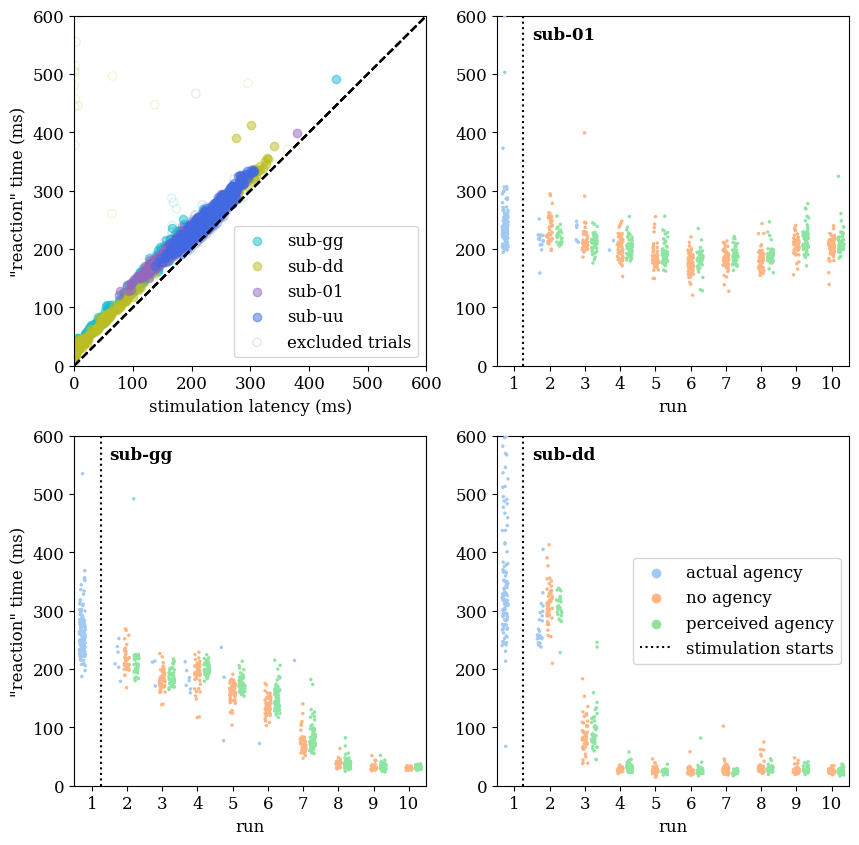

In [16]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize = (10, 10))
gs = gridspec.GridSpec(2, 2, wspace = .2, hspace = .2)

# plot agency over runs
ax = fig.add_subplot(gs[0, 1])
plot_sub_trials('01', ax)
ax.set_ylabel(None)
ax = fig.add_subplot(gs[1, 0])
plot_sub_trials('gg', ax)
ax = fig.add_subplot(gs[1, 1])
plot_sub_trials('dd', ax, legend = True)
ax.set_ylabel(None)

# plot 
ax = fig.add_subplot(gs[0, 0])
plot_sub_line('gg', 'tab:cyan', ax)
plot_sub_line('dd', 'tab:olive', ax)
plot_sub_line('01', 'tab:purple', ax)
plot_sub_line('uu', 'royalblue', ax)
ax.scatter([], [], facecolors = 'none', edgecolors = 'gray', alpha = .2, label = "excluded trials")
ax.set_xlabel("stimulation latency (ms)")
ax.set_ylabel("\"reaction\" time (ms)")
ax.legend()

fpath = os.path.join('figures', 'behavior.jpeg')
plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')
plt.show()

In [17]:
def extract(f):
    H0 = np.load(f)
    auc = H0[0]
    p = (H0 >= auc).mean()
    return auc, p

def get_sub_results(sub, return_diffs = False):
    if return_diffs:
        fs = [f for f in layout.get(subject = sub, suffix = 'auc') if 'V' in f.entities['desc']]
    else:
        fs = [f for f in layout.get(subject = sub, suffix = 'auc') if 'V' not in f.entities['desc']]
    aucs = {f.entities['desc']: extract(f)[0] for f in fs}
    ps = {f.entities['desc']: extract(f)[1] for f in fs}
    return aucs, ps

def get_decoding_results(return_diffs = False):
    subs = layout.get_subjects(scope = 'decoding', desc = 'cortex')
    res = [get_sub_results(sub, return_diffs) for sub in subs]
    aucs, ps = zip(*res)
    aucs, ps = pd.DataFrame(aucs, index = subs), pd.DataFrame(ps, index = subs)
    aucs = aucs[[c for c in aucs.columns.to_list() if not 'Group' in c]]
    ps = ps[[c for c in ps.columns.to_list() if not 'Group' in c]]
    return aucs, ps
    

auc, p = get_decoding_results()
print('AUROC:')
print(auc)
print('\np-values (vs. chance):')
print(p)

for col in p.columns:
    print('\n%s:'%col)
    _p, F = global_f_test(p[col], stat = True)
    print('Global F = %.03f, p = '%F, _p)

AUROC:
      cortex    theory  visuomotor
01  0.707364  0.600223    0.695929
dd  0.536430  0.520589    0.485726
gg  0.646709  0.637980    0.603157

p-values (vs. chance):
     cortex    theory  visuomotor
01  0.00020  0.000200     0.00020
dd  0.04819  0.167167     0.75045
gg  0.00020  0.000200     0.00020

cortex:
Global F = 40.135, p =  4.285633734323143e-07

theory:
Global F = 37.647, p =  1.316656129900846e-06

visuomotor:
Global F = 34.644, p =  5.0513719593102555e-06


In [18]:
diffs, p = get_decoding_results(return_diffs = True)
print(r'difference in AUROC:')
print(diffs)
print('\np-values (one-tailed):')
print(p)

for col in p.columns:
    print('\n%s:'%col)
    _p, F = global_f_test(p[col], stat = True)
    print('Global F = %.03f, p = '%F, _p)

difference in AUROC:
    cortexVtheory  cortexVvisuomotor  visuomotorVtheory
01       0.107141           0.011435           0.095706
dd       0.015841           0.050704          -0.034863
gg       0.008729           0.043552          -0.034823

p-values (one-tailed):
    cortexVtheory  cortexVvisuomotor  visuomotorVtheory
01       0.000200           0.298540           0.000200
dd       0.303739           0.023795           0.873825
gg       0.363927           0.038992           0.891422

cortexVtheory:
Global F = 21.440, p =  0.0015290368912758755

cortexVvisuomotor:
Global F = 16.383, p =  0.011839279349748568

visuomotorVtheory:
Global F = 17.534, p =  0.007507413731470899


In [19]:
def test_accuracy(layout, sub, model):
    '''
    tests whether the out-of-sample accuracy of the theory-based decoder is above chance 
    '''
    from scipy.special import expit
    from decoding import shuffle_within_runs, N_PERMUTATIONS
    print('\nsub-%s:'%sub)

    # load data
    if sub == 'group':
        df = load_logodds_group(layout)
        runs = df.sub_run.astype(int)
    else:
        df = layout.get(subject = sub, desc = 'predictions', suffix = 'logodds')[0].get_df()
        runs = df.run.astype(int)
    logodds = df[model].to_numpy() # out-of-sample predictions
    yhat = (expit(logodds) >= .5).astype(int) # convert to binary prediction
    y = df.y.astype(int)

    # permutation test
    H0 = [(y == yhat).mean()]
    for i in range(N_PERMUTATIONS):
        shuffled = shuffle_within_runs(yhat, runs, i)
        H0.append((y == shuffled).mean())
    H0 = np.array(H0)
    p = (H0 >= H0[0]).mean()
    print('accuracy = %.04f, p = %.05f\n'%(H0[0], p))
    
    return H0[0], p

test_accuracy(layout, 'group', 'theoryGroup')
ps = []
for sub in layout.get_subjects(scope = 'decoding', desc = 'theory'):
    _, p = test_accuracy(layout, sub, 'theory')
    ps.append(p)

p, stat = global_f_test(ps, stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


sub-group:
accuracy = 0.5582, p = 0.00020


sub-01:
accuracy = 0.5610, p = 0.00060


sub-dd:
accuracy = 0.5463, p = 0.02659


sub-gg:
accuracy = 0.5994, p = 0.00020


Global F = 39.126, p =  6.760524053028404e-07


In [20]:
test_accuracy(layout, 'group', 'visuomotorGroup')
ps = []
for sub in layout.get_subjects(scope = 'decoding', desc = 'visuomotor'):
    _, p = test_accuracy(layout, sub, 'visuomotor')
    ps.append(p)

p, stat = global_f_test(ps, stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


sub-group:
accuracy = 0.5822, p = 0.00020


sub-01:
accuracy = 0.6283, p = 0.00020


sub-dd:
accuracy = 0.4619, p = 0.92981


sub-gg:
accuracy = 0.5886, p = 0.00040


Global F = 32.829, p =  1.1311745715550191e-05


In [21]:
test_accuracy(layout, 'group', 'cortexGroup')
ps = []
for sub in layout.get_subjects(scope = 'decoding', desc = 'cortex'):
    _, p = test_accuracy(layout, sub, 'cortex')
    ps.append(p)

p, stat = global_f_test(ps, stat = True)
print('\nGlobal F = %.03f, p = '%stat, p)


sub-group:
accuracy = 0.6008, p = 0.00020


sub-01:
accuracy = 0.6385, p = 0.00020


sub-dd:
accuracy = 0.5193, p = 0.46271


sub-gg:
accuracy = 0.6037, p = 0.00020


Global F = 35.611, p =  3.280623705156092e-06


Testing whether using individual-specific masks from Session 1 improves decoding on Session 2:

In [22]:
df_indiv = load_logodds_group(layout, 'individual')
df_group = df[df.subject.isin(df_indiv.subject.unique())]
assert((df_group.subject == df_indiv.subject).mean() == 1.)
assert((df_group.y == df_indiv.y).mean() == 1.)

In [23]:
from decoding import permutation_test_paired
H0 = permutation_test_paired( # delta AUROC score (yhat0 - yhat1)
    df_group.y.to_numpy(), 
    df_indiv.theory.to_numpy(), # yhat0
    df_group.theoryGroup.to_numpy(), # yhat1
    df_group.sub_run.to_numpy()
)
p = (np.abs(H0[0]) <= np.abs(H0)).mean() # two-tailed p-value 
print('difference = %.03f, p = %f'%(H0[0], p))

Starting paired permutation test...
Got 6 parallel jobs after requesting -1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 2400 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 4416 tasks      | elapsed:  1.3min


difference = 0.048, p = 0.001600


[Parallel(n_jobs=-1)]: Done 5001 out of 5001 | elapsed:  1.4min finished
